# Cross-resonance gate between a transmon and a fluxonium: optimal gate time
In this notebook we study the cross-resonance two-qubit gate between a transmon and a fluxonium. 

In [1]:
import numpy as np
import scipy.integrate
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit import QubitSystem
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem
from pysqkit.solvers.solvkit import integrate
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit.solvers import solvkit
import qutip
import cmath
import multiprocessing
from functools import partial
import json
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import util_cr as util
import copy

from IPython.display import display, Latex

The gate is based on the following driven Hamiltonian of a fluxonium and a transmon capacitively coupled

$$H = H^{(0)}_T + H^{(0)}_F + V + H_{drive},$$

$$H^{(0)}_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b},$$

$$H^{(0)}_F = 4 E_{C,F} \cdot \hat{q}^2_F + \frac{1}{2}E_{L,F}\cdot\hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \phi_{ext,F}\right),$$

$$V = J_C \cdot \hat{q}_T \cdot \hat{q}_F,$$

$$\frac{H_{drive}}{h} = \left( \varepsilon_T \hat{q}_T + \varepsilon_F \hat{q}_F \right) \cos(2\pi f_d t).$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{q}_T = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger} - b),
$$
where 
$$
E_J = \hbar \biggl(\frac{\omega_T - \delta_T}{8 | \delta_T |} \biggr)^2.
$$

In the following we introduce relaxation due to dielectric loss and pure dephasing on each qubit as error channels. 

The idea behind the cross-resonance gate is to drive one of the qubit at the frequency of the other using the fact that due to the coupling we have a $Z X$ term in the Hamiltonian. In particular, we will explore the idea of driving the fluxonium at the transmon frequency. The opposite idea to drive the transmon at the fluxonium frequency does not seem that promising. However, one might evaluate using Raman transitions.

# Introducing the qubits and the coupled system

In [2]:
with open('flx_transm_params.txt') as param_file:
    parameters_set = json.load(param_file)

In [3]:
temperature = 0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

p_set = "1"


#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=parameters_set[p_set]["max_freq_t"], 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_t"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=parameters_set[p_set]["dephasing_times_t"]
)

#Fluxonium
levels_f = 5

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"], #8.0, 
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,
    dephasing_times= parameters_set[p_set]["dephasing_times_f"] #ns/2*np.pi 
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

jc = parameters_set[p_set]["jc"]
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

states_label = coupled_sys.all_state_labels()
states_dict = coupled_sys.states_as_dict(as_qobj=True)
flx_freq = flx.eig_energies(2)[1] - flx.eig_energies(2)[0]

In [4]:
state_label = ["00", "01", "10", "11"]
comp_states = {}
for label in state_label:
    state_tmp = coupled_sys.state(label)[1]
    loc = np.argmax(np.abs(state_tmp))
    phase = cmath.phase(state_tmp[loc])
    state_tmp = np.exp(-1j*phase)*state_tmp
    comp_states[label] = state_tmp

The basis principle behind the gate is illustrated in the following figure

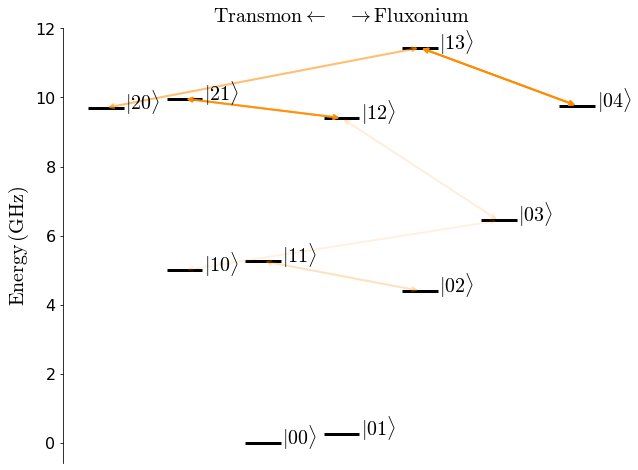

In [5]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04']

util.energy_levels_diagram(bare_system, level_list, show_drive=False)

The figure shows the energy of the bare levels. The orange arrows indicate the non-zero matrix elements between the (bare) levels provided by the capacitive coupling $V$: the more shaded the arrow the weaker the coupling. 
We look at the following quantities : 

$$\zeta_{ZZ} = E_{00} + E_{11} - E_{01} - E_{10}$$
$$r_{YZ} = \lvert \langle 10 | q_{F} | 00 \rangle - \langle 11 | q_{F} |01 \rangle \rvert $$
$$r_{Y} = \lvert \langle 10 | q_{F} | 00 \rangle + \langle 11 | q_{F} |01 \rangle \rvert $$

The second term quantifies the gate speed. Notice that if the phase of the drive is $0$ one hase a $YZ$ term from the charge operator. 

For the given parameters we have

In [6]:
def mu_yz_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2

def mu_yi_flx(comp_states, op) -> float:
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 + yz1))/2

The aim of the cross-resonance gate is to realize the following unitary
$$
\mathrm{CR}_{\theta} = e^{-i \frac{\theta}{2} X \otimes Z } = \cos\biggl(\frac{\theta}{2} \biggr) I -i \sin\biggl(\frac{\theta}{2} \biggr) X \otimes Z
$$

In particular it is known that $\mathrm{CR}_{-\pi/2}$ is equivalent to a CNOT up to single-qubit gates.

In [7]:
def func_to_minimize(
    pulse_time: list,
    t_rise: float,
    eps: float
) -> float:
    step = 1e-3
    n_points = int(pulse_time[0]/step)
    times = np.linspace(0, pulse_time[0], n_points)
    pulse = gaussian_top(times, t_rise, pulse_time[0])
    integral = scipy.integrate.simpson(2*np.pi*eps*pulse, times)
    return np.abs(integral - np.pi/2)   

In [8]:
eps_drive = 0.5 #GHz
q_op = coupled_sys["F"].charge_op()
op = coupled_sys["F"].charge_op()*eps_drive
freq_drive = transm.max_freq
omega_drive = np.abs(get_mat_elem(op, coupled_sys.state("01")[1], coupled_sys.state("11")[1]))
delta_drive = freq_drive - transm.max_freq
rabi_period = 1/np.sqrt(omega_drive**2 + delta_drive**2)
t_rise = 10.0 # [ns]

t_tot_0 = [100.0]

args_to_pass = (t_rise, np.abs(mu_yz_flx(comp_states, q_op))*eps_drive) 

# We find the total time to obtain the desired gate

start = time.time()

minimization_result = minimize(func_to_minimize, t_tot_0, args=args_to_pass)

print(minimization_result)

end = time.time()

t_tot = minimization_result['x'][0] #1/(util.y_z_flx(coupled_sys, 'F')*eps_drive*4)  # [ns]
print("t_tot: {} ns".format(t_tot))
pts_per_drive_period = 5

nb_points = int(t_tot*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_tot, nb_points)

coupled_sys['F'].drives['cr_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise, pulse_time=t_tot,
                                                 amp=eps_drive, freq=freq_drive)


      fun: 4.830180699855191e-11
 hess_inv: array([[1587.76187341]])
      jac: array([0.00655088])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 104
      nit: 1
     njev: 46
   status: 2
  success: False
        x: array([131.0958407])
t_tot: 131.0958407008805 ns


In [9]:
comp_states_list = []
for key in comp_states.keys():
    comp_states_list.append(comp_states[key])

In [10]:
def cry(theta):
    ide = np.identity(4)
    yz = np.kron(np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*yz

def ry(theta):
    rot_y = np.cos(theta/2)*np.identity(2) - 1j*np.sin(theta/2)*np.array([[0, -1j], [1j, 0]])
    return np.kron(rot_y, np.identity(2))

def get_fidelity_leakage(
    gate_time: float, 
    system: QubitSystem,
    t_rise: float,
    eps_drive:float,
    freq_drive: float,
    comp_states_list: List 
):
    pts_per_drive_period = 5.0

    nb_points = int(gate_time*freq_drive*pts_per_drive_period)
    tlist = np.linspace(0, gate_time, nb_points)

    system['F'].drives['cr_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise, pulse_time=gate_time, 
                                                amp=eps_drive, freq=freq_drive)
    
    simu_opt = qtp.solver.Options()
    simu_opt.atol = 1e-12
    simu_opt.rtol = 1e-10

    env_syst = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, options=simu_opt, 
                                          with_noise=False)
    
    n_process = 1

    sup_op = env_syst.to_super(comp_states_list, weyl_by_index)
    
    sq_corr = util.single_qubit_corrections(sup_op, weyl_by_index)
    sq_corr_sup = trf.kraus_to_super(sq_corr, weyl_by_index)
    total_sup_op = sq_corr_sup.dot(sup_op)
    
    cr_super_target = trf.kraus_to_super(cry(-np.pi/2), weyl_by_index)
    
    theta_list = list(np.linspace(0, 2*np.pi, 500))
    
    fid_list_ry = []
    for theta in theta_list:
        rot_y_super = trf.kraus_to_super(ry(theta), weyl_by_index)
        fid_list_ry.append(average_process_fidelity(cr_super_target, rot_y_super.dot(total_sup_op)))
    
    fid_ry = np.array(fid_list_ry)
    
    max_fid = np.max(fid_ry)
    max_index = np.argmax(fid_ry)
    sup_rot_y_opt = trf.kraus_to_super(ry(theta_list[max_index]), weyl_by_index)
    avg_leakage = env_syst.leakage(comp_states_list)
    
    f_gate = average_gate_fidelity(cr_super_target, sup_rot_y_opt.dot(total_sup_op), avg_leakage)
    
    result = {"gate_time": gate_time, "gate_fid": f_gate, "avg_leakage": avg_leakage}
    
    return result  

In [11]:
start = time.time()

result_test = get_fidelity_leakage(t_tot, coupled_sys, t_rise, eps_drive, freq_drive, comp_states_list)

end = time.time()

print("Computation time = {} s".format(end - start))

Computation time = 448.83132219314575 s


In [13]:
func = partial(get_fidelity_leakage, system=coupled_sys, t_rise=t_rise, eps_drive=eps_drive, 
               freq_drive=freq_drive, comp_states_list=comp_states_list)

In [14]:
n_points = 2
gate_time_list = np.linspace(t_tot - 5, t_tot + 5, n_points)

n_process = 2 # I see improvements till 8

start = time.time()
    
pool = multiprocessing.Pool(processes=n_process)
    
result = pool.map(func, gate_time_list, chunksize=int(n_points//n_process))
    
pool.close()
pool.join()  

end = time.time()

print("Computation time = {} s".format(end - start))

Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ciani/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ciani/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ciani/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ciani/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ciani/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ciani/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ciani/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  Fi

KeyboardInterrupt: 

In [25]:
save = True
if save:
    with open("tmp/fid_leak_gate_time_p_set_" + p_set + ".txt", "w") as fp:
        json.dump(result_test, fp)
    paramfile = open('tmp/cr_gate_time_params_p_set_' + str(p_set) + '.txt', "w+")
    paramfile.write('The data where generated using ')
    paramfile.write('the following drive parameters. \n ')
    paramfile.write('t_rise = %f ns' % t_rise + '\n')
    paramfile.write('freq_drive = %f GHz' % freq_drive + '\n')
    paramfile.write('eps_drive = %f GHz' % eps_drive + '\n')
    paramfile.write('parameter_set:\n')
    paramfile.write(str(parameters_set[p_set]))